In [1]:
!pip install torch
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 947.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.3 MB/s eta 0:00:00


In [2]:
import json
import os
import random
import re
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, DistilBertForSequenceClassification
from torch.cuda.amp import autocast, GradScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


In [3]:
# 'combined_list' now contains the combined data from all files
file_paths = ["dataset.json"]

dataset = []

for file_path in file_paths:
    with open(file_path, "r") as file:
        data = json.load(file)
        dataset.extend(data)


In [4]:
random.shuffle(dataset)
print(len(dataset))
print(dataset[0])

47136
{'pred': '/people/person/education./education/education/institution', 'sub': 'Cesar Ramos', 'obj': 'El Rancho High School', 'evidences': [{'url': 'http://en.wikipedia.org/wiki/Cesar_Ramos_(baseball)', 'snippet': 'Ramos attended El Rancho High School. He attended Long Beach State University, going 6--4 with a 2.85 ERA in 17 games, 14 starts, in . In , he went 12--4 with a 2.29 ERA in 19 starts, and in 2005 he went 10--7 with a 2.64 ERA in 18 starts.'}], 'judgments': [{'rater': '5346153820624061638', 'judgment': 'yes'}, {'rater': '10865367442061928261', 'judgment': 'yes'}, {'rater': '1666978224370465111', 'judgment': 'yes'}, {'rater': '15105723552637340343', 'judgment': 'yes'}, {'rater': '12086754839319333463', 'judgment': 'yes'}]}


In [5]:
# print the first 10 data points
for i in range(0,5):
  for key, value in dataset[i].items():
    if key == "pred":
      print(f"{key}:  {value}")

pred:  /people/person/education./education/education/institution
pred:  /people/person/education./education/education/institution
pred:  /people/person/education./education/education/institution
pred:  /people/person/place_of_birth
pred:  /people/person/education./education/education/institution


In [6]:
# Print the attributes
preds = []
for i in range(0,len(dataset)):
  for key, value in dataset[i].items():
    if key == "pred" and value not in preds:
      preds.append(value)

print(preds)
print(len(preds))


['/people/person/education./education/education/institution', '/people/person/place_of_birth', '/people/deceased_person/place_of_death', '/people/person/date_of_birth', '/people/person/education./education/education/degree']
5


In [7]:
# count the number of data points related to each attribute
pred_counts = Counter(entry['pred'] for entry in dataset)
print(pred_counts)


Counter({'/people/person/education./education/education/institution': 31991, '/people/person/place_of_birth': 8389, '/people/deceased_person/place_of_death': 2745, '/people/person/date_of_birth': 2282, '/people/person/education./education/education/degree': 1729})


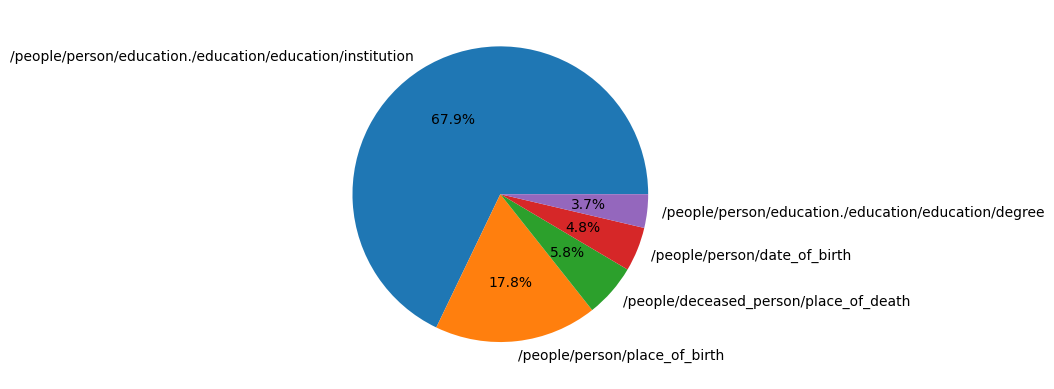

In [8]:
#  plot the pecentage of data points related to each attribute

pie_chart = plt.pie(pred_counts.values(), labels= preds, autopct='%1.1f%%')
plt.show(pie_chart)

In [9]:
# Define X and y based on your dataset
X = []  # List to store the features
y = []  # List to store the class labels

# Populate X and y from your dataset
for entry in dataset:
    # Extract features
    df_sub = entry['sub']  # Example feature extraction, replace with actual features
    df_obj = entry['obj']  # Another example feature extraction
    df_text = entry['evidences'][0]['snippet']

    # Extract class label
    class_label = entry['pred']

    # Append features to X
    X.append([df_sub, df_obj, df_text, class_label])  # Example, replace with actual features

    # Append class label to y
    y.append(class_label)



In [10]:
print(X[0])

['Cesar Ramos', 'El Rancho High School', 'Ramos attended El Rancho High School. He attended Long Beach State University, going 6--4 with a 2.85 ERA in 17 games, 14 starts, in . In , he went 12--4 with a 2.29 ERA in 19 starts, and in 2005 he went 10--7 with a 2.64 ERA in 18 starts.', '/people/person/education./education/education/institution']


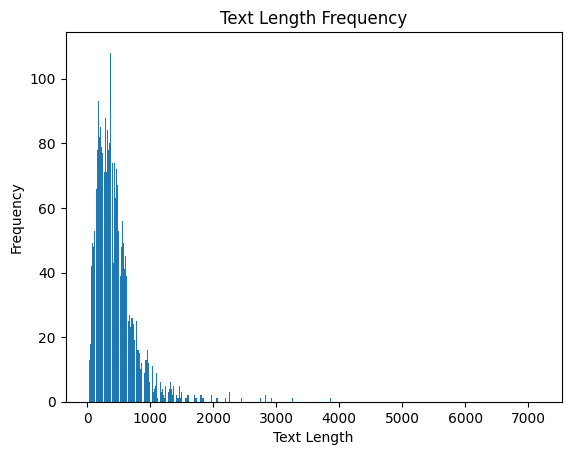

In [11]:
# Extract text lengths from X
text_lengths = [len(entry[2]) for entry in X]  # Assuming df_text is at index 2

# Count the frequency of each text length
text_length_freq = Counter(text_lengths)

# Extract lengths and frequencies for plotting
lengths = list(text_length_freq.keys())
frequencies = list(text_length_freq.values())

# Plotting
plt.bar(lengths, frequencies)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Frequency')
plt.show()


In [12]:
# Filter data with text length more than 600
filtered_X = [entry for entry in X if len(entry[2]) < 600]  # Assuming df_text is at index 2
filtered_y = [entry[3] for entry in filtered_X]  # Assuming class label is at index 3

# Now, you can use filtered_X and filtered_y for further analysis or plotting
print(len(filtered_X))

36052


In [13]:
Counter(filtered_y)

Counter({'/people/person/education./education/education/institution': 23480,
         '/people/person/place_of_birth': 7002,
         '/people/deceased_person/place_of_death': 2298,
         '/people/person/date_of_birth': 1927,
         '/people/person/education./education/education/degree': 1345})

In [14]:
sampling_strategy= {'/people/person/place_of_birth': 2200,
                    '/people/person/education./education/education/institution':2200,
                    '/people/deceased_person/place_of_death': 2200,
                    '/people/person/date_of_birth': 1927,
                    '/people/person/education./education/education/degree':1345

}

In [15]:
# undersample and oversample data
# Apply undersampling
under_sampling = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_undersample, y_undersample = under_sampling.fit_resample(filtered_X, filtered_y)

# Apply oversampling
over_sampling = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_balanced, y_balanced = over_sampling.fit_resample(X_undersample, y_undersample)

# Check the class distribution after balancing
print(Counter(y_balanced))


Counter({'/people/deceased_person/place_of_death': 2200, '/people/person/date_of_birth': 2200, '/people/person/education./education/education/degree': 2200, '/people/person/education./education/education/institution': 2200, '/people/person/place_of_birth': 2200})


In [16]:
random.shuffle(X_balanced)

In [17]:
for i in range(0,10):
  print(X_balanced[i])


["Patrick H. O'Farrell", 'Bachelor of Science', "Patrick H. O'Farrell received his ((NAM: B.Sc)). in 1969 from McGill University in Montreal, Quebec. He then went on to graduate school at the University of Colorado, Boulder, where he worked with Jacques Pène. To optimize the resolution of the Electrophoresis of the proteins, he needed to separate the proteins according to independent parameters. Two parameters were used:", '/people/person/education./education/education/degree']
['William J. Carney', 'Sheboygan South High School', 'William J. Carney, (January 27, 1927 - April 1, 2010), was a U.S. Veteran boardman. He was born in Youngstown, a son of William F. and Elsie Mae Woodall Carney. He was a graduate of South High School. He was a Navy veteran of WWII and the Korean War serving in the Pacific in both as a signalman. Carney worked in the Metallurgical Lab at Sheet and Tube and with Metropolitan Housing Authority until retirement.', '/people/person/education./education/education/in

In [18]:
from collections import defaultdict
degree_type =[]
category_examples = defaultdict(list)

for x in X_balanced:
  if x[3] == '/people/person/education./education/education/degree':
    degree_type.append(x[1])
    category_examples[x[1]].append(x[2])

# Count the occurrences of each degree type
degree_counter = Counter(degree_type)

# Sort the Counter dictionary by values
sorted_degree_counter = dict(sorted(degree_counter.items(), key=lambda item: item[1], reverse=True))

print(sorted_degree_counter)


{'Bachelor of Arts': 1077, 'Bachelor of Science': 380, 'Bachelor of Laws': 118, 'Bachelor of Fine Arts': 66, 'Doctor of Philosophy': 65, 'Master of Arts': 58, 'Master of Science': 51, 'Juris Doctor': 48, 'Honorary degree': 41, "Bachelor's degree": 40, 'Master of Business Administration': 24, 'Doctor of Letters': 22, 'Bachelor of Music': 18, 'Business administration': 16, 'Doctor of Humane Letters': 15, 'Master of Fine Arts': 12, 'Doctor of Medicine': 11, 'Bachelor of Engineering': 11, 'Bachelor of Technology': 9, 'Legum Doctor': 8, 'Bachelor of Commerce': 7, 'Bachelor of Philosophy': 7, 'Diplom': 5, 'Bachelor of Theology': 4, 'Semikhah': 4, 'Doctor of Divinity': 4, 'Doctor of Law': 4, 'Master of Public Administration': 4, 'Doctorate': 3, 'Doctor of Science': 3, 'Bachelor of Architecture': 3, 'Doctor of Juridical Science': 3, 'Crimea Medal': 3, 'Queen Elizabeth II Coronation Award': 3, 'Hero': 3, 'Order of Merit of the Federal Republic of Germany': 3, 'Dental degree': 3, 'Oscar Carré Tr

In [52]:


# Mapping list of degree categories to their corresponding degree abbreviations
degree_mapping = {
    "Bachelor of Laws": "B.L.",
    "Bachelor of Arts": "B.A.",
    "Bachelor of Science": "B.Sc",
    "Bachelor of Fine Arts": "BFA",
    "Bachelor of Philosophy": "Ph.B.",
    "Master of Arts": "M.A.",
    "Doctor of Medicine": "M.D.",
    "Master of Business Administration": "MBA",
    "Juris Doctor": "J.D.",
    "Bachelor of Technology": "B.Tech",
    "Bachelor of Music": "Mus.B.",
    "Bachelor of Engineering": "BSEE",
    "Doctor of Philosophy": "Ph.D",
    "Master of Science": "M.Sc.",
    "Business administration": "B.B.A.",
    "Legum Doctor": "LL.D.",
    "Master of Social Work": "M.S.W.",
    "Bachelor of Theology": "Th.B.",
    "Bachelor of Education": "B.Ed",
    "Doctor of Divinity": "D.D.",
    "Doctor of Education": "Ed.D.",
    "Bachelor of Electrical Engineering": "B.E.E.",
    "Master of Laws": "LL.M."
}


def extract_degree(text, degree_object):
    marked_text = text
    # Find the corresponding degree abbreviation for the given degree object
    degree_abbr = degree_mapping.get(degree_object)
    if degree_abbr:
        # Escape the degree abbreviation
        degree_abbr_escaped = re.escape(degree_abbr)
        # Create a regex pattern for the degree abbreviation
        pattern = r'\b' + degree_abbr_escaped + r'\W'
        # Search for the pattern in the text
        match = re.search(pattern, marked_text)
        # If a match is found, replace the abbreviation with the full degree name in the text
        if match:
            marked_text = re.sub(pattern, f'{degree_object}', marked_text)
    return marked_text
'''
# Test the function
text = "Born in Omaha, Nebraska, Schatz received an ((NAM: B.A.)) from the University of Nebraska in 1943 and was a U.S."
degree_object = "Bachelor of Arts"
marked_text = extract_degree(text, degree_object)
print(marked_text)
'''

Born in Omaha, Nebraska, Schatz received an ((NAM: Bachelor of Arts) from the University of Nebraska in 1943 and was a U.S.


In [21]:
import re

text_list = []

for item in X_balanced:
    subject = item[0]
    obj = item[1]
    text = item[2]
    label = item[3]

    if label == '/people/person/education./education/education/degree':
      text = extract_degree(text, obj)

    # Escape special characters in subject and object for regex
    subject_regex = re.escape(subject)
    obj_regex = re.escape(obj)

    # Define regular expression patterns to match variations of subject and object names
    subject_pattern = r'\b' + subject_regex + r'\b|\b' + re.escape(subject.split()[0]) + r'\b|\b' + re.escape(subject.split()[-1]) + r'\b'  # Match full, first or last name
    obj_pattern = r'\b' + obj_regex + r'\b|\b' + re.escape(obj.split()[0]) + r'\b|\b' + re.escape(obj.split()[-1]) + r'\b'  # Match full, first or last name

    # Marking subject and object in the text
    text_with_markings = re.sub(subject_pattern, '[E1]' + subject + '[/E1]', text, flags=re.IGNORECASE)
    text_with_markings = re.sub(obj_pattern, '[E2]' + obj + '[/E2]', text_with_markings, flags=re.IGNORECASE)
    text_list.append([subject, obj, label, text_with_markings])

# Print marked text for the first 10 entries for inspection
for marked_text in text_list[:10]:
    print(marked_text)


["Patrick H. O'Farrell", 'Bachelor of Science', '/people/person/education./education/education/degree', "[E1]Patrick H. O'Farrell[/E1] received his ((NAM: [E2]Bachelor of Science[/E2]). in 1969 from McGill University in Montreal, Quebec. He then went on to graduate school at the University of Colorado, Boulder, where he worked with Jacques Pène. To optimize the resolution of the Electrophoresis of the proteins, he needed to separate the proteins according to independent parameters. Two parameters were used:"]
['William J. Carney', 'Sheboygan South High School', '/people/person/education./education/education/institution', '[E1]William J. Carney[/E1], (January 27, 1927 - April 1, 2010), was a U.S. Veteran boardman. He was born in Youngstown, a son of [E1]William J. Carney[/E1] F. and Elsie Mae Woodall [E1]William J. Carney[/E1]. He was a graduate of South High [E2]Sheboygan South High School[/E2]. He was a Navy veteran of WWII and the Korean War serving in the Pacific in both as a signal

In [22]:
text_length=[]
for i in range(len(text_list)):
  text_length.append(len(text_list[i][3]))


In [23]:
print(max(text_length))

953


In [24]:
max_length_index = text_length.index(max(text_length))
print("Index of text with maximum length:", max_length_index)


Index of text with maximum length: 6759


In [25]:
print(text_list[max_length_index])

['Adrian Zmed', 'The Theatre School at DePaul University', '/people/person/education./education/education/institution', "He graduated with a BFA from [E2]The Theatre School at DePaul University[/E2] famed Goodman School of Drama. His first major acting gig was [E2]The Theatre School at DePaul University[/E2] role of [E2]The Theatre School at DePaul University[/E2] male lead, Danny Zuko, in [E2]The Theatre School at DePaul University[/E2] national touring company production of Grease. He later appeared in [E2]The Theatre School at DePaul University[/E2] Broadway stage musical three times, twice in [E2]The Theatre School at DePaul University[/E2] role of Zuko. In [E2]The Theatre School at DePaul University[/E2] original Broadway production of Grease, he starred with Jeff Conaway, who played Kenickie in [E2]The Theatre School at DePaul University[/E2] 1978 motion picture Grease. Aged 40, [E1]Adrian Zmed[/E1] revived [E2]The Theatre School at DePaul University[/E2] role of Danny Zuko durin

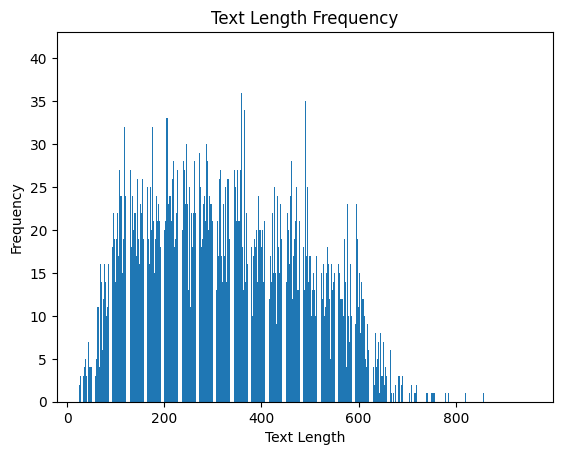

In [26]:

# Count the frequency of each text length
text_length_freq = Counter(text_length)

# Extract lengths and frequencies for plotting
lengths = list(text_length_freq.keys())
frequencies = list(text_length_freq.values())

# Plotting
plt.bar(lengths, frequencies)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Frequency')
plt.show()


In [27]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Define the mapping between labels and encoded numbers
label_mapping = {
    '/people/person/education./education/education/institution': 0,
    '/people/deceased_person/place_of_death': 1,
    '/people/person/place_of_birth': 2,
    '/people/person/date_of_birth': 3,
    '/people/person/education./education/education/degree': 4
}

# Fit the label encoder with the specified mapping
label_encoder.fit(list(label_mapping.values()))

# Extract the labels from X_balanced
classes = [entry[2] for entry in text_list]

# Transform the labels using the fitted label encoder
encoded_labels = [label_mapping[label] for label in classes]

# Update the labels in X_balanced
for i, entry in enumerate(text_list):
    entry.append(encoded_labels[i])


In [28]:
text_list[3]

['Gerald and Sara Murphy',
 'East Hampton',
 '/people/deceased_person/place_of_death',
 '[E1]Gerald and Sara Murphy[/E1] died October 17, 1964 in [E2]East Hampton[/E2]. Sara died on October 10, 1975 in Arlington, Virginia.',
 1]

In [29]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', pad_token= '[PAD]')
from torch.nn.utils.rnn import pad_sequence

# Define a function to pad or truncate sequences
def pad_sequences(seq, max_length):
    if len(seq) < max_length:
        # Pad with [PAD] tokens if the sequence is shorter than max_length
        padding = ['[PAD]'] * (max_length - len(seq))
        return seq + padding
    else:
        # Truncate if the sequence is longer than max_length
        return seq[:max_length]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
# Define your max sequence length
max_seq_length = 128

# Initialize lists to store tokenized inputs and labels
inputs_text = []
labels = []

# Process each data point in the dataset
for data_point in text_list:
    text = data_point[3]

    # Tokenize the subject, object, and text using BERT tokenizer
    tokenized_text = tokenizer.tokenize(text)

    # Truncate or pad the tokenized sequences to the specified max sequence length
    tokenized_text = tokenized_text[:max_seq_length - 2]

    # Add [CLS] and [SEP] tokens to the subject, object, and text
    tokenized_text = ['[CLS]'] + tokenized_text + ['[SEP]']

    # Pad the sequences to the specified max sequence length using your pad_sequences function
    paded_text = pad_sequences(tokenized_text, max_seq_length)

    # Convert the tokenized subject, object, and text to input IDs
    input_ids_text = tokenizer.convert_tokens_to_ids(paded_text)


    # Append the input IDs to the inputs lists
    inputs_text.append(input_ids_text)

    # Label the relevant entities and their relationships
    relation_label = data_point[4]

    # Create a label string with relation label
    label = relation_label

    # Add the label to the labels list
    labels.append(label)


In [32]:
print(f"sub: {text_list[0][0]},\nobj: {text_list[0][1]},\ntext: {text_list[0][3]},\nlabel: {text_list[0][4]},\nclass: {text_list[0][2]} ")
print(f"\nlabel: {labels[0]},\ninputs_text: {inputs_text[0]}")
print(len(inputs_text[0]))


sub: Patrick H. O'Farrell,
obj: Bachelor of Science,
text: [E1]Patrick H. O'Farrell[/E1] received his ((NAM: [E2]Bachelor of Science[/E2]). in 1969 from McGill University in Montreal, Quebec. He then went on to graduate school at the University of Colorado, Boulder, where he worked with Jacques Pène. To optimize the resolution of the Electrophoresis of the proteins, he needed to separate the proteins according to independent parameters. Two parameters were used:,
label: 4,
class: /people/person/education./education/education/degree 

label: 4,
inputs_text: [101, 1031, 1041, 2487, 1033, 4754, 1044, 1012, 1051, 1005, 16248, 1031, 1013, 1041, 2487, 1033, 2363, 2010, 1006, 1006, 15125, 1024, 1031, 1041, 2475, 1033, 5065, 1997, 2671, 1031, 1013, 1041, 2475, 1033, 1007, 1012, 1999, 3440, 2013, 17919, 2118, 1999, 5548, 1010, 5447, 1012, 2002, 2059, 2253, 2006, 2000, 4619, 2082, 2012, 1996, 2118, 1997, 5169, 1010, 13264, 1010, 2073, 2002, 2499, 2007, 7445, 7279, 2063, 1012, 2000, 23569, 27605,

In [33]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
train_input, val_input, train_labels, val_labels = train_test_split(inputs_text, labels, test_size=0.3,stratify= labels ,random_state=42)

# Further split the validation set into validation and test sets
val_input, test_input, val_labels, test_labels = train_test_split(val_input, val_labels, test_size=0.5, random_state=42)


In [34]:
train_input_tns = torch.tensor(train_input)
train_labels_tns = torch.tensor(train_labels)

val_input_tns = torch.tensor(val_input)
val_labels_tns = torch.tensor(val_labels)

test_input_tns = torch.tensor(test_input)
test_labels_tns = torch.tensor(test_labels)

In [35]:
# Create a TensorDataset from the input tensors and labels
train_dataset = TensorDataset(train_input_tns, train_labels_tns)

val_dataset = TensorDataset(val_input_tns, val_labels_tns)

test_dataset = TensorDataset(test_input_tns, test_labels_tns)

# Define batch size and create DataLoader instances
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [36]:

# Step 3: Define the BERT model architecture
# Load pre-trained BERT model and add a classification layer on top
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Optional: Freeze BERT layers if desired
for param in model_bert.bert.parameters():
    param.requires_grad = False

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

# Wrap the model with DataParallel
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model_bert)

# print(model_bert)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:

# Define the Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

alpha = 1.0
gamma = 2.5  # You can experiment with different gamma values
focal_loss_fn = FocalLoss(alpha=alpha, gamma=gamma)

In [38]:
# Step 5: Fine-tune the BERT model
# from transformers import BertAdamW

# loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Define the optimizer and learning rate
optimizer = AdamW(model_bert.parameters(), lr=2e-5)

# Number of training epochs
num_epochs = 100

# Define the learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Create a GradScaler object for mixed precision training
scaler = GradScaler()

# Create an array to save train loss (will be used in the plot)
train_loss_array = []

# Training loop
for epoch in range(num_epochs):
    model_bert.train()
    total_loss = 0
    accumulated_loss = 0
    average_accumulated_loss = 0

    for step, batch in enumerate(train_dataloader):
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model_bert(inputs_text, labels= labels)
            logits = outputs.logits

            # Use the Focal Loss function here
            loss = focal_loss_fn(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = total_loss / len(train_dataloader)

    # Validation loop
    model_bert.eval()
    val_loss = 0
    num_val_steps = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs_text,  labels = batch
            inputs_text, labels = inputs_text.to(device), labels.to(device)

            outputs = model_bert(inputs_text)
            logits = outputs.logits

            loss = focal_loss_fn(logits, labels)
            val_loss += loss.item()
            num_val_steps += 1

    avg_val_loss = val_loss / num_val_steps

    # Perform learning rate scheduling
    # scheduler.step()
    if epoch % 5 ==0:
      print(f"Epoch {epoch}/{num_epochs}, Train_Loss: {avg_train_loss:.4f}, Val_Loss: {avg_val_loss:.4f}")

    train_loss_array.append(avg_train_loss)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 0/100, Train_Loss: 0.9180, Val_Loss: 0.8873
Epoch 5/100, Train_Loss: 0.8818, Val_Loss: 0.8418
Epoch 10/100, Train_Loss: 0.8617, Val_Loss: 0.8171
Epoch 15/100, Train_Loss: 0.8461, Val_Loss: 0.7991
Epoch 20/100, Train_Loss: 0.8393, Val_Loss: 0.7850
Epoch 25/100, Train_Loss: 0.8233, Val_Loss: 0.7725
Epoch 30/100, Train_Loss: 0.8157, Val_Loss: 0.7624
Epoch 35/100, Train_Loss: 0.8151, Val_Loss: 0.7547
Epoch 40/100, Train_Loss: 0.8044, Val_Loss: 0.7458
Epoch 45/100, Train_Loss: 0.7963, Val_Loss: 0.7393
Epoch 50/100, Train_Loss: 0.7927, Val_Loss: 0.7332
Epoch 55/100, Train_Loss: 0.7827, Val_Loss: 0.7258
Epoch 60/100, Train_Loss: 0.7822, Val_Loss: 0.7195
Epoch 65/100, Train_Loss: 0.7726, Val_Loss: 0.7133
Epoch 70/100, Train_Loss: 0.7670, Val_Loss: 0.7073
Epoch 75/100, Train_Loss: 0.7645, Val_Loss: 0.7027
Epoch 80/100, Train_Loss: 0.7601, Val_Loss: 0.6978
Epoch 85/100, Train_Loss: 0.7606, Val_Loss: 0.6923
Epoch 90/100, Train_Loss: 0.7525, Val_Loss: 0.6880
Epoch 95/100, Train_Loss: 0.7490,

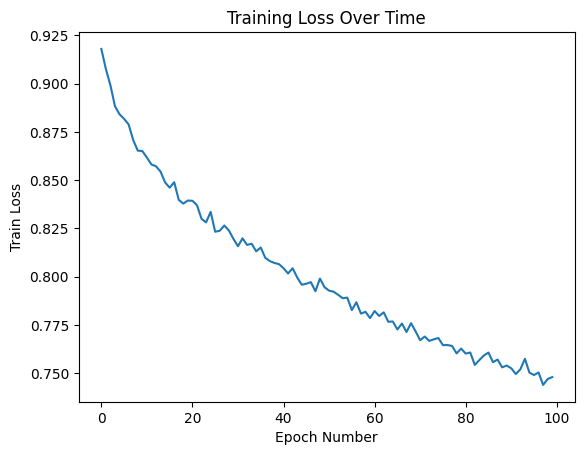

In [40]:
train_loss_np =[]
for t in train_loss_array:
  train_loss_np.append(t.item())

# Create the plot
plt.plot(train_loss_array)
# Adding a title
plt.title('Training Loss Over Time')

# Adding labels for the x and y axes
plt.xlabel('Epoch Number')
plt.ylabel('Train Loss')

plt.show()


In [41]:
def compute_accuracy(predictions, labels):
    predicted_labels = torch.argmax(predictions, dim=1)
    correct_predictions = torch.eq(predicted_labels, labels).sum().item()
    accuracy = correct_predictions / len(labels)
    return accuracy



In [42]:
# step 6: evaluate the model by computing  accuracy, precision, recall, and F1-score
# Evaluation loop
model_bert.eval()
val_accuracy = 0
num_val_steps = 0

with torch.no_grad():
    for batch in val_dataloader:
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        outputs = model_bert(inputs_text)
        val_accuracy += compute_accuracy(outputs.logits, labels)
        num_val_steps += 1

avg_val_accuracy = val_accuracy / num_val_steps

print(f"Validation Accuracy: {avg_val_accuracy:.4f}")


Validation Accuracy: 0.5180


In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluation loop
model_bert.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        outputs = model_bert(inputs_text)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())


In [44]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.47      0.28      0.35       368
           1       0.75      0.58      0.66       318
           2       0.35      0.22      0.27       307
           3       0.37      0.52      0.43       347
           4       0.44      0.72      0.55       310

    accuracy                           0.46      1650
   macro avg       0.48      0.47      0.45      1650
weighted avg       0.48      0.46      0.45      1650



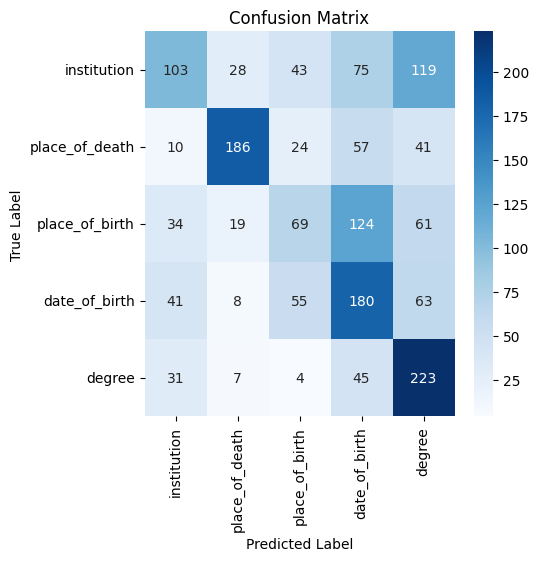

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['institution', 'place_of_death', 'place_of_birth', 'date_of_birth', 'degree'], yticklabels=['institution', 'place_of_death', 'place_of_birth', 'date_of_birth', 'degree'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()